In [2]:
import re
import numpy as np
import pandas as pd
from sklearn import preprocessing
from scipy.sparse import csr_matrix
from sklearn.cluster import DBSCAN
from tqdm import tqdm
from sklearn import metrics
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline


# Demo of DBSCAN clustering algorithm


Finds core samples of high density and expands clusters from them.




In [3]:
states = ["INITIAL","login","View_Items","home","logout","View_Items_quantity","Add_to_Cart","shoppingcart",
          "remove","deferorder","purchasecart","inventory","sellinventory","clearcart","cancelorder","$"]

#Data imports
PATH = "../../data/raw/"
sessions_file = (PATH+'sessions.dat')
#Dict of sessions
with open(sessions_file) as fn:
    sessions_raw = fn.readlines()

def session_request_dict(sessions_raw):
    s_r_dict = {}
    for session in sessions_raw:
        key = re.search('([^.]+)', session).group()
        value = re.findall('\"(.*?)\"', session)
        s_r_dict[key] = value

    return s_r_dict

In [6]:
def transition_matrix(sessions, states):
    markovchains = []
    for key, value in sessions.items():
        # labelEncoding
        le = preprocessing.LabelEncoder()
        le.fit(value)
        transformed_s = le.transform(value)

        # factorize
        factorize = pd.factorize(value)[0]

        # matrix
        n = 1 + max(factorize)  # number of states
        M = [[0] * n for _ in range(n)]

        for (i, j) in zip(factorize, factorize[1:]):
            M[i][j] += 1

        # now convert to probabilities:
        for row in M:
            s = sum(row)
            if s > 0:
                row[:] = [f / s for f in row]

        # unique array in the right order
        value = np.array(value)
        _, idx = np.unique(value, return_index=True)

        df = pd.DataFrame(data=M, index=value[np.sort(idx)],
                          columns=value[np.sort(idx)])

        df_1 = pd.DataFrame(index=states, columns=states, dtype='float64')

        merge = df_1.update(df, join='left')
        merge = pd.concat([pd.concat([df_1, df], axis=1, sort=False)], axis=0).fillna(0).round(2).iloc[:, :-n]

        # convert into Vector
        merge = np.array(merge.values.flatten().tolist())
        # 2-D array
        markovchains.append(merge)
        # csr sparse matrix
        csr = csr_matrix(markovchains)



    return csr

data = session_request_dict(sessions_raw)
small_data_set = {k: data[k] for k in list(data)[:1000]}

X = transition_matrix(small_data_set, states)
#print('matrix done')
#print('start clustering')

clustering = DBSCAN(eps=1.5, min_samples=10).fit(X)
labels = clustering.labels_
print(np.unique(labels, return_counts=True))
print(clustering)

(array([0, 1, 2], dtype=int64), array([485, 261, 254], dtype=int64))
DBSCAN(algorithm='auto', eps=1.5, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=10, n_jobs=None, p=None)


In [48]:
from scipy.spatial import distance
a = X[1].toarray()
b = X[2].toarray()
dst = distance.euclidean(a, b)
dst

2.00124960961895

In [5]:
dist = np.linalg.norm(a-b)
dist

2.00124960961895

Source:


https://stackoverflow.com/questions/1401712/how-can-the-euclidean-distance-be-calculated-with-numpy/1401828

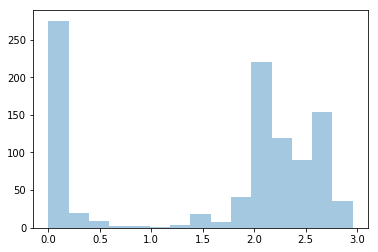

In [19]:
dist_list = []
for i in range(X.shape[0]):
    #print(i)
    try:
        j = i+1
        dist_list.append(np.linalg.norm(X[i].toarray()-X[j].toarray()))
    except IndexError:
        pass
    
#print(dist_list)
sns.distplot(dist_list, bins=15,kde=False)

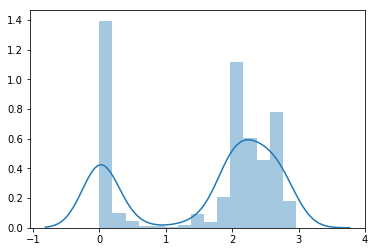

In [15]:
sns.distplot(dist_list, bins=15)

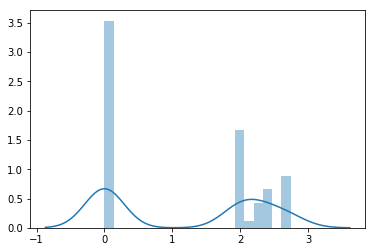

In [10]:
dist_list = []
for i in range(X.shape[0]):
    #print(i)
    try:
        j = i+1
        dist_list.append(np.linalg.norm(X[0].toarray()-X[i].toarray()))
    except IndexError:
        pass
    
#print(dist_list)
sns.distplot(dist_list, bins=20)

Source: 


http://www-m9.ma.tum.de/material/felix-klein/clustering/Methoden/Dichteverbundenes_Clustern.php

https://github.com/alitouka/spark_dbscan/wiki/Choosing-parameters-of-DBSCAN-algorithm

https://iopscience.iop.org/article/10.1088/1755-1315/31/1/012012/pdf